In [1]:
#### import packages ####

# os stuff
import sys
import os

#pandas and numpy
import pandas as pd
import numpy as np

#shap
import shap

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#sklearn packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, precision_score, recall_score

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set paths for preprocessor
sys.path.append('/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
)

from feature_engineer import preprocessor

In [3]:
#LightGBM
import lightgbm
from lightgbm import LGBMClassifier

In [4]:
#optuna
import optuna

In [6]:
# read the csv_file and preprocess
df = pd.read_csv("../Data/train.csv")
preprocessor(df)

In [8]:
scoring = {
    'accuracy' : make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall'   : make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score)
}

In [9]:
## Baseline model
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features]


nfeatures=['user_edit_count','user_distinct_pages',
             'user_warns','num_edits_5d_before', 
            'num_recent_edits','num_recent_reversions',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score'
            ]

pipe = Pipeline([
    ('scorer', VandalismScorer(n_splits=5, random_state=42)),
    ('select', FeatureSelector(nfeatures)),
    ('model', LGBMClassifier(objective='binary',
              metric='binary_logloss',
              verbosity = -1,
              boosting_type='gbdt',
              force_col_wise=True,
              random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
baseline_scores = cross_validate(
    pipe, df.copy(), df['isvandalism'].copy(),
    cv=cv, scoring=scoring
)

print("Baseline LightGBM Classifier Scores:")
for metric in scoring.keys():
    mean_score = baseline_scores[f'test_{metric}'].mean()
    print(f"{metric}: {mean_score:.4f}")

Baseline LightGBM Classifier Scores:
accuracy: 0.9142
precision: 0.9252
recall: 0.8961
f1_score: 0.9104


Baseline LightGBM Classifier Scores:
* accuracy: 0.9142
* precision: 0.9252
* recall: 0.8961
* f1_score: 0.9104

In [11]:
def train(
    predictor: pd.DataFrame,
    target: pd.Series,
    cv: StratifiedKFold,
    scoring: str = "accuracy",
) -> None:


    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 256),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 5, 12),
            'random_state': 42
        }

        nfeatures = ['user_edit_count','user_distinct_pages',
             'user_warns','num_edits_5d_before', 
            'num_recent_edits','num_recent_reversions',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score'
            ]


        pipe = Pipeline([('scorer', VandalismScorer(n_splits=5, random_state=42)),
                  ('select', FeatureSelector(nfeatures)),
                  ('model', LGBMClassifier(**params))
                  ])

        score = cross_val_score(
                        pipe, predictor.copy(), target.copy(),
                        cv=cv, scoring='accuracy'
                        ).mean()
        return score

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    print("Optuna Optimization Results")
    print("Best Accuracy:", study.best_value)
    print("Best hyperparameters:", study.best_params)

    return study.best_params, study.best_value


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_params, best_score = train(df, df.isvandalism, cv)

Optuna Optimization Results
Best Accuracy: 0.915447808026429
Best hyperparameters: {'learning_rate': 0.019047994719728283, 'num_leaves': 128, 'n_estimators': 736, 'max_depth': 9}


## Old code

In [ ]:
def shap_rfe(
    predictor: pd.DataFrame,
    target: pd.Series,
    cv,
    scoring: str = "accuracy",
    drop_threshold: float = 0.01,
    min_features: int = 1,
) -> tuple[float, list[str]]:
    features = predictor.columns.tolist()
    model = LGBMClassifier(random_state=42, verbosity=-1)
    initial_score = cross_val_score(
        model, predictor, target, cv=cv, scoring=scoring
    ).mean()

    performance = [(len(features), initial_score)]
    print(f"Start: {len(features)} features → {scoring}: {initial_score:.4f}")

    best_score = initial_score
    best_features = features.copy()

    while len(features) > min_features:
        model = LGBMClassifier(random_state=42, verbosity=0)
        model.fit(predictor[features], target)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(predictor[features])

        mean_shap = np.abs(shap_values).mean(axis=0)
        shap_df = pd.DataFrame({"feature": features, "mean_shap": mean_shap})
        shap_df = shap_df.sort_values(by="mean_shap")

        feature_to_drop = shap_df.iloc[0]["feature"]
        features.remove(feature_to_drop)

        score = cross_val_score(
            LGBMClassifier(random_state=42, verbosity=0),
            predictor[features],
            target,
            cv=cv,
            scoring=scoring,
        ).mean()

        if score > best_score:
            best_score = score
            best_features = features.copy()

        performance.append((len(features), score))

        if best_score - score > drop_threshold:
            break

    lengths, scores = zip(*performance)
    plt.figure(figsize=(10, 6))
    plt.plot(lengths, scores, marker="o")
    plt.xlabel("Number of Features")
    plt.ylabel(scoring.capitalize())
    plt.title("RFE Performance vs. Number of Features")
    plt.gca().invert_xaxis()
    plt.grid(True)
    plt.show()

    return best_score, best_features


In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
target = "isvandalism"
features_1 = [
    "user_edit_count",
    "user_distinct_pages",
    "user_warns",
    "num_recent_edits",
    "num_recent_reversions",
    "num_edits_5d_before",
    "account_age",
    "word_count_added",
    "word_count_deleted",
    "vandalism_score",
    "comment_empty",
    "is_IP",
    "current_minor",
    "is_person",
]


best_params, best_score = train(df[features_1], df[target], cv)

Baseline accuracy score: 0.9251
Optuna Optimization Results
Best Accuracy: 0.927403089669871
Best hyperparameters: {'learning_rate': 0.027425528114638015, 'num_leaves': 26, 'n_estimators': 570, 'max_depth': 9}


Original Features:
Start: 14 features → accuracy: 0.9251


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local

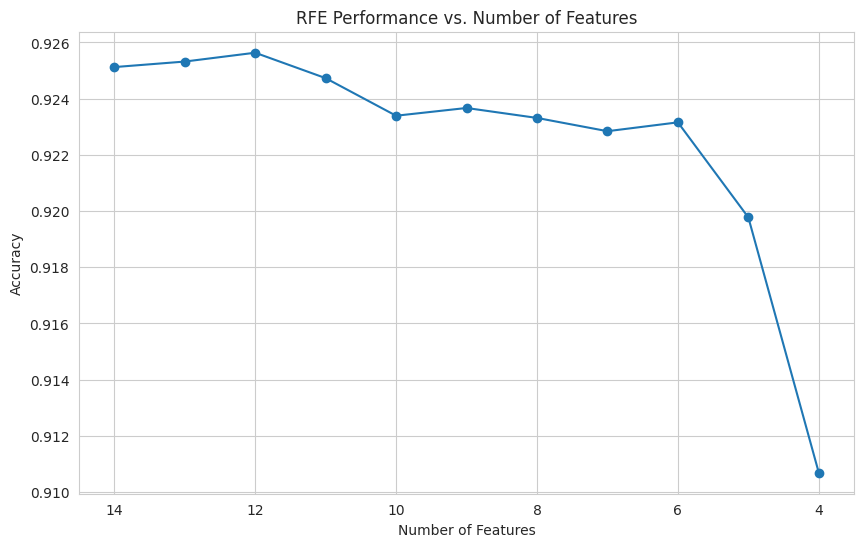

In [ ]:
print("Original Features:")
best_score_1, best_features_1 = shap_rfe(df[features_1], df[target], cv)

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 256),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 12)
    }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, df[features], df[target], cv=cv, scoring='accuracy').mean()
    return score

#optuna tuning
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best accuracy:", study.best_value)
print("Best hyperparameters:", study.best_params)

Best f1: 0.9122232920285643
Best hyperparameters: {'learning_rate': 0.00828031828213807, 'num_leaves': 74, 'n_estimators': 341, 'max_depth': 11}


Optimizing $F_1$ score with $n=10$ trials, we get the following result:


```
Best f1: 0.9083058881728933
Best hyperparameters: {'learning_rate': 0.013126799624277498, 'num_leaves': 92, 'n_estimators': 311, 'max_depth': 5}
```



Optimizing `accuracy_score` with $n=10$ trials, we get the following result:


```
Best accuracy: 0.9122232920285643
Best hyperparameters: {'learning_rate': 0.00828031828213807, 'num_leaves': 74, 'n_estimators': 341, 'max_depth': 11}
```



In [ ]:
# Train/test split
from sklearn.model_selection import train_test_split
df_tt, df_ho = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)

# Final model
final_model = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    verbosity=-1,
    boosting_type='gbdt',
    learning_rate=study.best_params["learning_rate"],
    num_leaves=study.best_params['num_leaves'],
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth']
)

final_model.fit(df_tt[features], df_tt[target])
preds = final_model.predict(df_ho[features])

accuracy = accuracy_score(df_ho[target], preds)
confmat = confusion_matrix(df_ho[target], preds)
print("Final Accuracy:", accuracy)
print("Confusion Matrix:\n", confmat)

Final Accuracy: 0.9089657884388518
Confusion Matrix:
 [[2376  234]
 [ 229 2247]]
